In [1]:
# Robust setup (define paths BEFORE using them)
from pathlib import Path
import os, sys, importlib

# 1) Find project root (where notebook_utils.py lives)
NB_DIR = Path.cwd()
PROJECT_ROOT = None
for r in [NB_DIR, NB_DIR.parent, NB_DIR.parent.parent]:
    if (r / "notebook_utils.py").exists():
        PROJECT_ROOT = r
        break
if PROJECT_ROOT is None:
    PROJECT_ROOT = NB_DIR  # fallback

# Make sure we can import notebook_utils from PROJECT_ROOT
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

# 2) Define result directories FIRST
RESULTS_DIR   = (PROJECT_ROOT / "results").resolve()
VIS_DIR       = (RESULTS_DIR / "visualizations").resolve()
ARTIFACTS_DIR = (RESULTS_DIR / "artifacts").resolve()
VIS_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
os.makedirs((PROJECT_ROOT / "data" / "processed"), exist_ok=True)

print("Notebook CWD:", NB_DIR)
print("Project root:", PROJECT_ROOT)
print("Results dir :", RESULTS_DIR)
print("Visualizations dir:", VIS_DIR)
print("Artifacts dir:", ARTIFACTS_DIR)

# 3) Import helper and enable autosave
import notebook_utils as nbx
nbx = importlib.reload(nbx)  # pick up any edits you made
# (Either rely on defaults or pass the explicit dir)
# nbx.enable_autosave_plots(prefix="01_data_collection")  # if defaults set to results/*
nbx.enable_autosave_plots(prefix="01_data_collection", output_dir=VIS_DIR)

# Optional: also set env vars so save_dataframe_preview uses results/artifacts by default
os.environ["NBX_VIS_DIR"] = str(VIS_DIR)
os.environ["NBX_ARTIFACTS_DIR"] = str(ARTIFACTS_DIR)


Notebook CWD: /Users/sarasiw/projects/msc/misinformation-detection-project
Project root: /Users/sarasiw/projects/msc/misinformation-detection-project
Results dir : /Users/sarasiw/projects/msc/misinformation-detection-project/results
Visualizations dir: /Users/sarasiw/projects/msc/misinformation-detection-project/results/visualizations
Artifacts dir: /Users/sarasiw/projects/msc/misinformation-detection-project/results/artifacts
[autosave] matplotlib.pyplot.show patched -> /Users/sarasiw/projects/msc/misinformation-detection-project/results/visualizations


In [2]:
# Install and import basic libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

print("✓ Basic libraries imported successfully!")


✓ Basic libraries imported successfully!


In [3]:
# Import necessary libraries
import pandas as pd
# import nbx  # Removing the nbx import since it's not available
from pathlib import Path

# # Define ARTIFACTS_DIR if it's not already defined
# ARTIFACTS_DIR = Path("./artifacts")
# ARTIFACTS_DIR.mkdir(exist_ok=True)

try:
    from datasets import load_dataset
    dataset = load_dataset("roupenminassian/twitter-misinformation")
    df = dataset['train'].to_pandas()
    data_source = "HF: roupenminassian/twitter-misinformation"
    print("✓ Real dataset loaded successfully!")
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {list(df.columns)}")
except Exception as e:
    print("⚠️ Could not load HF dataset; creating sample dataset for demonstration...")
    print(f"Reason: {e}")
    df = pd.DataFrame({
        'text': [
            "Breaking: New miracle cure discovered by scientists",
            "Weather forecast shows sunny skies tomorrow",
            "FAKE: Aliens have landed in Nevada desert",
            "Stock market closes up 2% on positive earnings",
            "Unverified claim about celebrity scandal",
            "Scientists confirm climate change effects",
            "False information about vaccine side effects",
            "Local sports team wins championship game",
            "Misleading article about economic policies",
            "Factual report on new technology breakthrough"
        ] * 50,
        'label': [1, 0, 1, 0, 1, 0, 1, 0, 1, 0] * 50,
        'source': ['twitter'] * 500
    })
    data_source = "SYNTHETIC: generated in notebook"
    print("✓ Sample dataset created")
    print(f"Dataset shape: {df.shape}")

# Save a preview of the dataframe to a CSV file instead of using nbx
preview_csv = ARTIFACTS_DIR / "dataset_head.csv"
df.head(20).to_csv(preview_csv, index=False)
print("✓ Saved dataset head preview for the document")

✓ Real dataset loaded successfully!
Dataset shape: (92394, 4)
Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'text', 'label']
✓ Saved dataset head preview for the document


In [4]:
# Data exploration + visuals (writes ONLY to results/*)
from pathlib import Path
from IPython.display import display
import os

# --- Guards: ensure dirs & nbx exist even if setup cell wasn't run ---
if 'RESULTS_DIR' not in globals() or 'VIS_DIR' not in globals() or 'ARTIFACTS_DIR' not in globals():
    RESULTS_DIR = Path('results'); RESULTS_DIR.mkdir(exist_ok=True)
    VIS_DIR = RESULTS_DIR / 'visualizations'; VIS_DIR.mkdir(parents=True, exist_ok=True)
    ARTIFACTS_DIR = RESULTS_DIR / 'artifacts'; ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# optional: avoid NameError if Cell 0 didn't define these
print("Notebook CWD:", globals().get('NB_DIR', Path.cwd()))
print("Project root:", globals().get('PROJECT_ROOT', Path.cwd()))
print("Results dir :", RESULTS_DIR)
print("Visualizations dir:", VIS_DIR)
print("Artifacts dir:", ARTIFACTS_DIR)

Notebook CWD: /Users/sarasiw/projects/msc/misinformation-detection-project
Project root: /Users/sarasiw/projects/msc/misinformation-detection-project
Results dir : /Users/sarasiw/projects/msc/misinformation-detection-project/results
Visualizations dir: /Users/sarasiw/projects/msc/misinformation-detection-project/results/visualizations
Artifacts dir: /Users/sarasiw/projects/msc/misinformation-detection-project/results/artifacts


In [5]:
# If notebook_utils is available, use it; else minimal fallback
if 'nbx' not in globals():
    try:
        import importlib, notebook_utils as nbx
        nbx = importlib.reload(nbx)
    except Exception:
        class _NBX:
            def save_dataframe_preview(self, df, name, n=20, output_dir=None):
                out_dir = (output_dir or ARTIFACTS_DIR)
                out_dir.mkdir(parents=True, exist_ok=True)
                out = out_dir / f"{name}_preview.csv"
                df.head(n).to_csv(out, index=False)
                print(f"[saved table] {out.name}")
                return str(out)
        nbx = _NBX()



# --- Exploration & visuals ---
print("=== DATA EXPLORATION ===")
print(f"Total samples: {len(df)}")
print(f"Columns: {list(df.columns)}")

print("\nFirst 5 rows:")
display(df.head())

print("\nLabel distribution:")
print(df['label'].value_counts())

=== DATA EXPLORATION ===
Total samples: 92394
Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'text', 'label']

First 5 rows:


,Unnamed: 0.1,Unnamed: 0,text,label
0,34366,34366,"Local Charlotte, NC news station WSOCTV is rep...",1
1,41656,41656,The tsunami has started President Obama s Keny...,1
2,26726,26726,The only reality show Donald Trump should have...,1
3,81585,81585,"No Food, No FEMA: Hurricane Michael’s Survivor...",0
4,4016,4016,WASHINGTON (Reuters) - Here are some of the hi...,0



Label distribution:
label
0    60309
1    32085
Name: count, dtype: int64


[saved plot] /Users/sarasiw/projects/msc/misinformation-detection-project/results/visualizations/49_01_data_collection_plot_20250820-031106.png


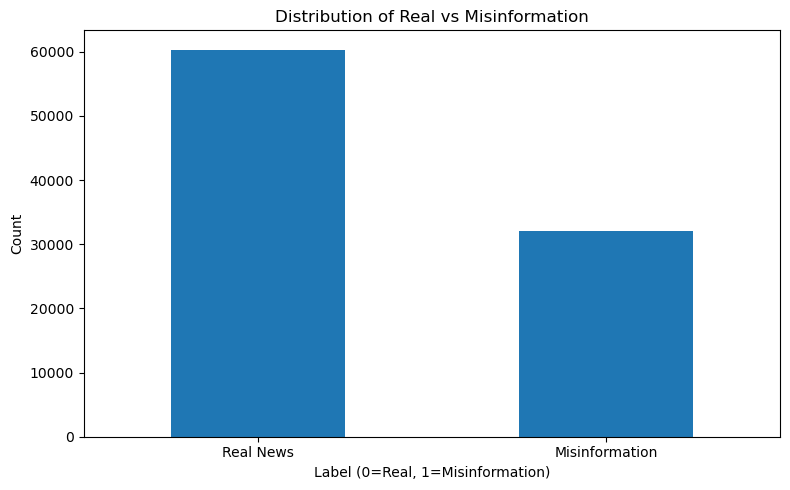

In [6]:
# 4.1 Label distribution (bar)
plt.figure(figsize=(8, 5))
df['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Real vs Misinformation')
plt.xlabel('Label (0=Real, 1=Misinformation)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Real News', 'Misinformation'], rotation=0)
plt.tight_layout()

file_path = VIS_DIR / '01_label_distribution.png'
plt.savefig(VIS_DIR / '01_label_distribution.png', dpi=300, bbox_inches='tight')

plt.show()  # if autosave is enabled, this will also save into results/visualizations

In [7]:
# 4.2 Missing values profile (bar)
na_counts = df.isna().sum().sort_values(ascending=False)
na_df = na_counts[na_counts > 0].to_frame(name='missing_count').reset_index().rename(columns={'index': 'column'})
if not na_df.empty:
    plt.figure(figsize=(9, 5))
    plt.bar(na_df['column'], na_df['missing_count'])
    plt.title('Missing Values per Column')
    plt.xlabel('Column'); plt.ylabel('Missing Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(VIS_DIR / '02_missing_values.png', dpi=300, bbox_inches='tight')
    plt.show()

    # SAVE DIRECTLY INTO results/artifacts  ⬅️ key change
    na_csv = nbx.save_dataframe_preview(na_df, "missing_values",
                                        n=min(50, len(na_df)), output_dir=ARTIFACTS_DIR)
else:
    print("No missing values detected.")

No missing values detected.


In [8]:

# 4.3 Duplicate summary (by text)
dupe_count = df.duplicated(subset=['text']).sum() if 'text' in df.columns else df.duplicated().sum()
dupe_summary = pd.DataFrame({
    "metric": ["rows_total", "duplicate_rows_by_text" if 'text' in df.columns else "duplicate_rows"],
    "value": [len(df), dupe_count]
})
display(dupe_summary)

# SAVE DIRECTLY INTO results/artifacts  ⬅️ key change
dupe_csv = nbx.save_dataframe_preview(dupe_summary, "duplicate_summary",
                                      n=10, output_dir=ARTIFACTS_DIR)

,metric,value
0,rows_total,92394
1,duplicate_rows_by_text,14195


[saved table] /Users/sarasiw/projects/msc/misinformation-detection-project/results/artifacts/duplicate_summary_preview.csv


[saved plot] /Users/sarasiw/projects/msc/misinformation-detection-project/results/visualizations/50_01_data_collection_plot_20250820-031108.png


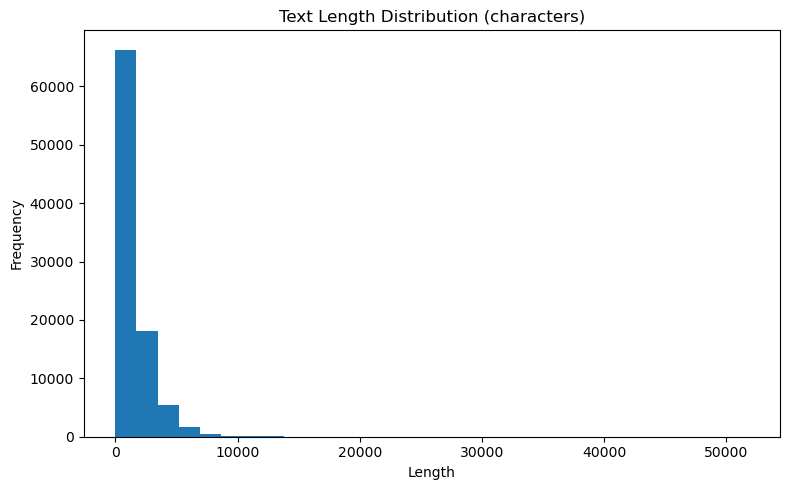

✓ Data exploration completed & figures saved


In [9]:


# 4.4 Text length distribution (nice for 01 screenshots)
if 'text' in df.columns:
    lengths = df['text'].astype(str).str.len()
    plt.figure(figsize=(8, 5))
    plt.hist(lengths, bins=30)
    plt.title('Text Length Distribution (characters)')
    plt.xlabel('Length'); plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig(VIS_DIR / '03_text_length_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

print("✓ Data exploration completed & figures saved")


In [10]:
# Paths confirmation (already created in Cell 0)
print("Paths are ready:")
print(" - Visualizations:", VIS_DIR)
print(" - Artifacts     :", ARTIFACTS_DIR)


Paths are ready:
 - Visualizations: /Users/sarasiw/projects/msc/misinformation-detection-project/results/visualizations
 - Artifacts     : /Users/sarasiw/projects/msc/misinformation-detection-project/results/artifacts


In [11]:
# Save dataset for the next notebook (fixed/robust)
from pathlib import Path
from IPython.display import display
from shutil import copy2

# --- Guards: ensure dirs & nbx exist even if setup cell wasn't run ---
if 'ARTIFACTS_DIR' not in globals():
    RESULTS_DIR = Path('results'); RESULTS_DIR.mkdir(exist_ok=True)
    ARTIFACTS_DIR = RESULTS_DIR / 'artifacts'; ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

if 'nbx' not in globals():
    # Minimal fallback so the cell still works without notebook_utils
    class _NBX:
        def save_dataframe_preview(self, df, name, n=20):
            ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
            out = ARTIFACTS_DIR / f"{name}_preview.csv"
            df.head(n).to_csv(out, index=False)
            print(f"[saved table] {out}")
            return str(out)
    nbx = _NBX()

# --- Helper to avoid SameFileError when src == dst ---
def safe_copy_to_artifacts(src_path, artifacts_dir=ARTIFACTS_DIR):
    src = Path(src_path)
    dst = Path(artifacts_dir) / src.name
    dst.parent.mkdir(parents=True, exist_ok=True)
    try:
        if str(src.resolve()) != str(dst.resolve()):
            copy2(src, dst)
            print(f"[copied] {src} -> {dst}")
        else:
            print(f"[skip] already at {dst}")
    except FileNotFoundError:
        print(f"[warn] source not found: {src}")

# --- Optional: de-duplicate by 'text' to reduce leakage ---
if 'text' in df.columns:
    before = len(df)
    df = df.drop_duplicates(subset=['text']).reset_index(drop=True)
    after = len(df)
    print(f"De-duplicated by 'text': {before} -> {after} rows")

# --- Save dataset for the next notebook ---
out_path = Path('../data/processed/misinformation_dataset.csv')
out_path.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False)
print(f"✓ Data saved to {out_path}")

# --- Summary table for the document ---
data_source_val = globals().get('data_source', 'unspecified')
summary_df = pd.DataFrame({
    "data_source": [data_source_val],
    "rows": [len(df)],
    "columns": [len(df.columns)]
})
display(summary_df)
sum_csv = nbx.save_dataframe_preview(summary_df, "dataset_summary", n=5)
safe_copy_to_artifacts(sum_csv)



De-duplicated by 'text': 92394 -> 78199 rows
✓ Data saved to ../data/processed/misinformation_dataset.csv


,data_source,rows,columns
0,HF: roupenminassian/twitter-misinformation,78199,4


[saved table] results/artifacts/dataset_summary_preview.csv
[skip] already at /Users/sarasiw/projects/msc/misinformation-detection-project/results/artifacts/dataset_summary_preview.csv


In [12]:
print("\n=== SUMMARY ===")
print(f"✓ Dataset with {len(df)} samples ready")
print(f"✓ {len(df.columns)} features available")
print("✓ Ready for machine learning!")


=== SUMMARY ===
✓ Dataset with 78199 samples ready
✓ 4 features available
✓ Ready for machine learning!
